In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

# Load the data

In [2]:
import datetime
from helpers import *

height, weight, gender = load_data(sub_sample=True, add_outlier=True)
x, mean_x, std_x = standardize(height)
y, tx = build_model_data(x, weight)

In [3]:
y.shape, tx.shape

((202,), (202, 2))

# Computing the Cost Function
Fill in the the `compute_cost` function below:

In [4]:
def compute_loss(y, tx, w):
    loss = np.sum((y - tx.dot(w))**2)/(2*y.shape[0])    
    return loss
w = np.r_[2, 1]
compute_loss(y, tx, w)

2713.1646079600109

# Grid Search

Fill in the function `grid_search()` below:

In [5]:
def grid_search(y, tx, w0, w1):
    """Algorithm for grid search."""
    losses = np.zeros((len(w0), len(w1)))
    for i in range(len(w0)):
        for j in range(len(w1)):
            w = np.r_[w0[i],w1[j]]
            losses[i,j] = compute_loss(y, tx, w)
    return losses

Let us play with the grid search demo now!

Grid Search: loss*=109.17758755205352, w0*=66.66666666666669, w1*=16.666666666666686, execution time=0.006 seconds


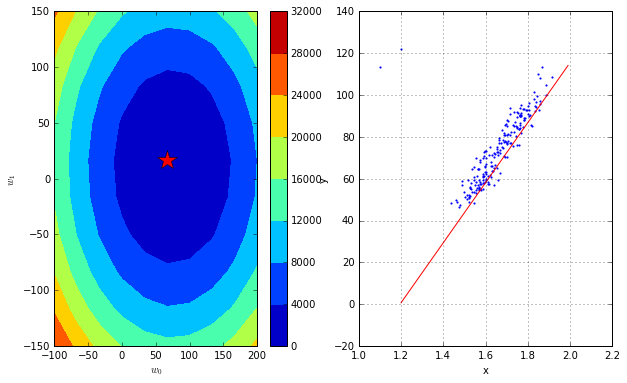

In [6]:
from grid_search import generate_w, get_best_parameters
from plots import grid_visualization
import datetime

# Generate the grid of parameters to be swept
grid_w0, grid_w1 = generate_w(num_intervals=10)

# Start the grid search
start_time = datetime.datetime.now()
grid_losses = grid_search(y, tx, grid_w0, grid_w1)

# Select the best combinaison
loss_star, w0_star, w1_star = get_best_parameters(grid_w0, grid_w1, grid_losses)
end_time = datetime.datetime.now()
execution_time = (end_time - start_time).total_seconds()

# Print the results
print("Grid Search: loss*={l}, w0*={w0}, w1*={w1}, execution time={t:.3f} seconds".format(
      l=loss_star, w0=w0_star, w1=w1_star, t=execution_time))

# Plot the results
fig = grid_visualization(grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight)
fig.set_size_inches(10.0,6.0)
fig.savefig("grid_plot")  # Optional saving

# Gradient Descent

Again, please fill in the functions `compute_gradient` below:

In [7]:
def compute_gradient(y, tx, w):
    gradient = - np.dot(np.transpose(tx), y - np.dot(tx, w))/y.shape[0]
    return gradient
w = np.r_[100, 10]
compute_gradient(y, tx, w)

array([ 25.93219415,  -1.03489487])

In [8]:
w = np.r_[50, 10]
compute_gradient(y, tx, w)

array([-24.06780585,  -1.03489487])

Please fill in the functions `gradient_descent` below:

In [9]:
def gradient_descent(y, tx, initial_w, max_iters, gamma): 
    """Gradient descent algorithm."""
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    for n_iter in range(max_iters):
        loss = compute_loss(y, tx, w)
        gradient = compute_gradient(y, tx, w)
        w = w - gamma*gradient
        # store w and loss
        ws.append(np.copy(w))
        losses.append(loss)
        print("Gradient Descent({bi}/{ti}): loss={l}, w0={w0}, w1={w1}".format(
              bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]))

    return losses, ws

Test your gradient descent function through gradient descent demo shown below:

In [10]:
from plots import gradient_descent_visualization

# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.4

# Initialization
w_initial = np.array([0.0, 0.0])

# Start gradient descent.
start_time = datetime.datetime.now()
gradient_losses, gradient_ws = gradient_descent(y, tx, w_initial, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("Gradient Descent: execution time={t:.3f} seconds".format(t=exection_time))

Gradient Descent(0/49): loss=2869.8351145358524, w0=29.62712234197053, w1=4.413957946395668
Gradient Descent(1/49): loss=1075.3363084985738, w0=47.403395747152864, w1=7.062332714233058
Gradient Descent(2/49): loss=429.31673832515264, w0=58.06915979026227, w1=8.65135757493549
Gradient Descent(3/49): loss=196.749693062721, w0=64.46861821612791, w1=9.604772491356941
Gradient Descent(4/49): loss=113.0255567682457, w0=68.30829327164729, w1=10.17682144120981
Gradient Descent(5/49): loss=82.88486770223464, w0=70.61209830495892, w1=10.52005081112153
Gradient Descent(6/49): loss=72.03421963847063, w0=71.99438132494589, w1=10.725988433068562
Gradient Descent(7/49): loss=68.1279863355156, w0=72.82375113693809, w1=10.849551006236778
Gradient Descent(8/49): loss=66.72174234645178, w0=73.3213730241334, w1=10.923688550137706
Gradient Descent(9/49): loss=66.21549451038881, w0=73.61994615645058, w1=10.968171076478264
Gradient Descent(10/49): loss=66.03324528940614, w0=73.79909003584089, w1=10.994860592

<function __main__.plot_figure>

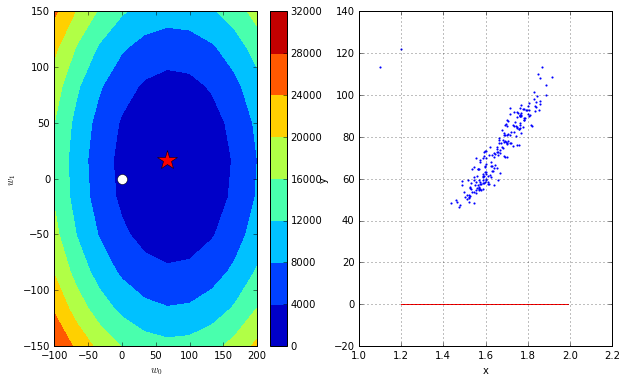

In [11]:
# Time Visualization
from ipywidgets import IntSlider, interact
def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        gradient_losses, gradient_ws, grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight, n_iter)
    fig.set_size_inches(10.0, 6.0)

interact(plot_figure, n_iter=IntSlider(min=1, max=len(gradient_ws)))

# Stochastic gradient descent

In [12]:
def compute_stoch_gradient(y, tx, w):
    """Compute a stochastic gradient for batch data."""
    stoch_gradient = - np.sum(np.dot(y - np.dot(tx, w),np.ones(tx.shape))*tx,axis=0)/y.shape[0]
    return stoch_gradient

def stochastic_gradient_descent(
        y, tx, initial_w, batch_size, max_epochs, gamma):
    """Stochastic gradient descent algorithm."""
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    n_epoch = -1
    for minibatch_y, minibatch_tx in batch_iter(y, tx, batch_size, max_epochs):
        loss = compute_loss(y, tx, w)
        stoch_gradient = compute_stoch_gradient(minibatch_y, minibatch_tx, w)
        w = w - gamma*stoch_gradient
        # store w and loss
        ws.append(np.copy(w))
        losses.append(loss)
        n_epoch = n_epoch + 1
        print("Stochastic Gradient Descent({bi}/{ti}): loss={l}, w0={w0}, w1={w1}".format(
        bi=n_epoch, ti=max_epochs - 1, l=loss, w0=w[0], w1=w[1]))
    return losses, ws

In [13]:
# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.4
batch_size = 1

# Initialization
w_initial = np.array([0.0, 0.0])

# Start SGD.
start_time = datetime.datetime.now()
gradient_losses, gradient_ws = stochastic_gradient_descent(
    y, tx, w_initial, batch_size, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SGD: execution time={t:.3f} seconds".format(t=exection_time))

Stochastic Gradient Descent(0/49): loss=2869.8351145358524, w0=26.412398718172405, w1=-6.948754150274894
Stochastic Gradient Descent(1/49): loss=1363.1554607575808, w0=56.55508061895375, w1=30.909262054793146
Stochastic Gradient Descent(2/49): loss=416.77373827564435, w0=58.33476309803372, w1=32.2517930302797
Stochastic Gradient Descent(3/49): loss=414.77343115464794, w0=76.39665745125372, w1=1.7013320910018734
Stochastic Gradient Descent(4/49): loss=112.20020201877524, w0=67.48000418620924, w1=12.129464699692354
Stochastic Gradient Descent(5/49): loss=88.22933707620601, w0=108.41175654692563, w1=-149.8608512403474
Stochastic Gradient Descent(6/49): loss=13599.404762227185, w0=205.54289055874315, w1=15.919631753814002
Stochastic Gradient Descent(7/49): loss=8720.710006272142, w0=151.84278926573646, w1=-41.308232761576036
Stochastic Gradient Descent(8/49): loss=4460.306257296278, w0=137.23152534328997, w1=-51.93658812082225
Stochastic Gradient Descent(9/49): loss=4043.462294684077, w0=9

<function __main__.plot_figure>

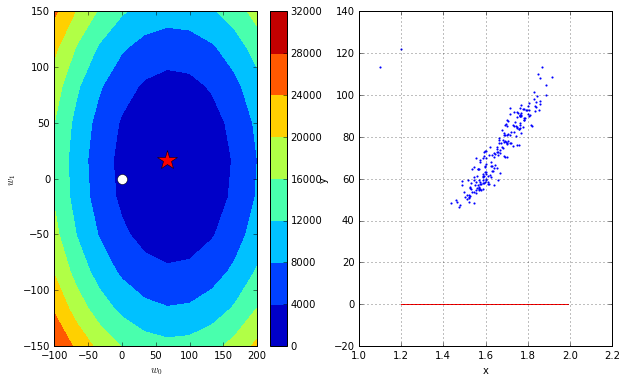

In [14]:
# Time Visualization
from ipywidgets import IntSlider, interact
def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        gradient_losses, gradient_ws, grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight, n_iter)
    fig.set_size_inches(10.0, 6.0)

interact(plot_figure, n_iter=IntSlider(min=1, max=len(gradient_ws)))